In [433]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
import pandas as pd
import itertools
from scipy.interpolate import interp1d

Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks
You will investigate the five hallmarks of stochastic SIR dynamics using an event drive
SIR model:
1. variability;
2. negative co-variances;
3. increased transients;
4. stochastic resonance;
5. extinctions.


In [434]:
def sir(variables, t, beta, gamma):
    S = variables[0]
    I = variables[1]
    R = variables[2]

    N = S + I + R

    dSdt = -beta * I * S / N
    dIdt = beta * I * S / N - gamma * I
    dRdt = gamma * I

    return([dSdt, dIdt, dRdt])

Implement Gillespies algorithm
Write some python code to implement Gillespies Algorithm (GA)1
. You should define the
events and the rates of each event for the SIR model. Keep in mind it may be insightful
to compare the GA stochastic simulation with an equivalent deterministic ODE model.
BONUS: You can also think about (and implement) a way to control the noise level in
the GA.

In [435]:
# Gillespies algorithm
def Gillespies(S, I, R, t, tend, beta, gamma, std_scaler=1):
    run_count = 0
    while t[-1] < tend and (S[-1] + I[-1] >= 1):
        # Get Population
        N = S[-1] + I[-1] + R[-1]

        # Get the probablities: [S -> I, I -> R]
        props = [beta*I[-1]*S[-1]/N, gamma*I[-1]]

        # Get sum of probability
        prop_sum = sum(props)

        try: 
                
                # Determine the time until the next event occurs based on the probabilty sum.
                tau = np.random.exponential(scale=std_scaler*(1/prop_sum))
                t.append(t[-1]+tau) 

                # Generate random number    
                rand = random.uniform(0,1)

                # See if Susceptible becomes Infected
                if rand * prop_sum <= props[0]:
                        S.append(S[-1] - 1)
                        I.append(I[-1] + 1)
                        R.append(R[-1])

                # Else, Infected becomes Recovered
                else:
                        S.append(S[-1])
                        I.append(I[-1] - 1)
                        R.append(R[-1] + 1)

        
        except ZeroDivisionError:
                print(f"ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count{run_count}")
                run_count += 1
                if run_count> 10: 
                       print("Stochastic extinction is happening to often, choose different parameters")
                       break

    return np.array(S), np.array(I), np.array(R)
        

In [436]:
# Initial conditions
S_init = [200]
I_init = [1]
R_init = [0]
t = [0]


tend = 500

# Parameters
beta = 0.04
gamma = 0.01

In [437]:
S, I, R = Gillespies(S_init, I_init, R_init, t, tend, beta, gamma)

In [438]:
def RMSE(x, y):
    if not len(x) == len(y):
        raise ValueError("x and y must be of same length")
    return np.sqrt(np.mean(np.square(x - y)))

In [439]:
y0 = [200, 1, 0]
y = odeint(sir, y0, t, args=(beta, gamma))

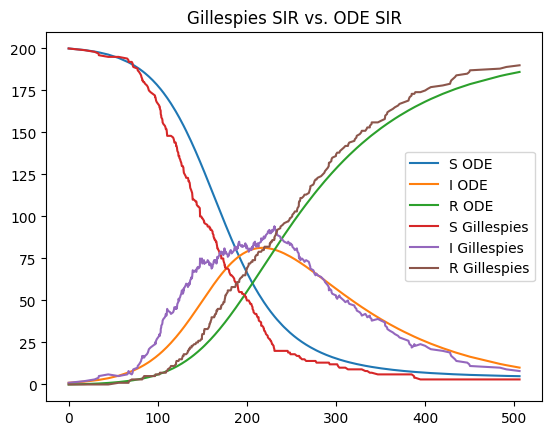

In [440]:
# plot the results

plt.plot(t,y[:,0], label = "S ODE" ) # S
plt.plot(t,y[:,1], label = "I ODE") # I
plt.plot(t,y[:,2], label = "R ODE") # R

plt.plot(t, S, label = "S Gillespies")
plt.plot(t, I, label = "I Gillespies")
plt.plot(t, R, label = "R Gillespies")
plt.title('Gillespies SIR vs. ODE SIR')
plt.legend()




plt.show()

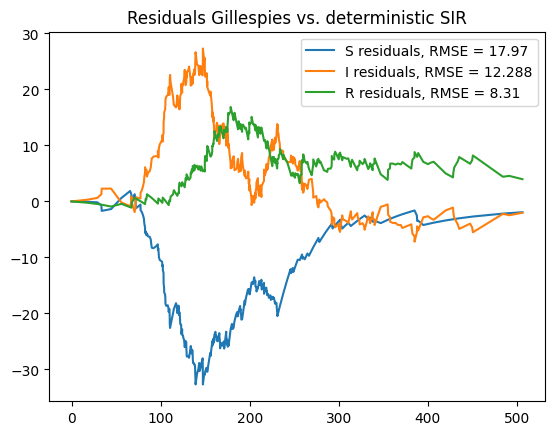

In [441]:
# plottings residuals & MSE
plt.plot(t, np.subtract(S, y[:,0]), label = f'S residuals, RMSE = {round(RMSE(S, y[:,0]),3)}')
plt.plot(t, np.subtract(I, y[:,1]), label = f'I residuals, RMSE = {round(RMSE(I, y[:,1]),3)}')
plt.plot(t, np.subtract(R, y[:,2]), label = f'R residuals, RMSE = {round(RMSE(R, y[:,2]),3)}')
plt.title('Residuals Gillespies vs. deterministic SIR')
plt.legend()
plt.savefig('Residuals Gillespies vs. deterministic SIR.png')
plt.show()


Trying to control the noise in the stochastic model, defined as the lowest RMSE vs. the deterministic ODE

In [442]:
# Params
S_init = [200]
I_init = [10]
R_init = [0]
t = [0]
tend = 500
beta = 0.04
gamma = 0.01
n_runs = 10



In [443]:
# params
betas = np.round(np.linspace(0.1, 1, 5),3)
gammas = np.round(np.linspace(1, 0.1, 5),3)
combinations_beta_gamma = list(itertools.product(betas, gammas))

In [444]:
S_init

[200]

In [445]:
# (S, I, R, t, tend, beta, gamma, std_scaler=1)

data = Gillespies(S=S_init, I=I_init, R=R_init, t=t, tend=tend, beta = 1, gamma = 0.5)

ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count0
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count1
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count2
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count3
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words wh

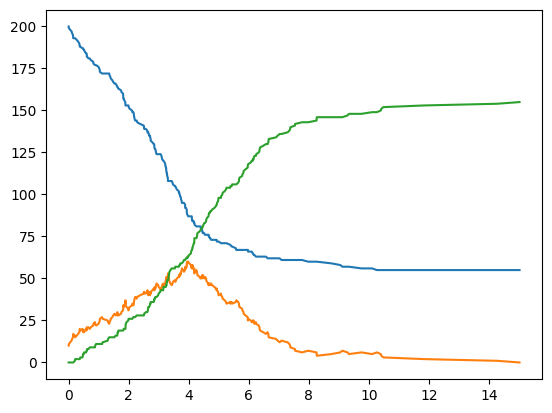

In [446]:
S, I, R = data
plt.plot(t, S, label = "S")
plt.plot(t, I, label = "I")
plt.plot(t, R, label = "R")

In [447]:
# len(combinations_beta_gamma)

In [448]:
columns = ['beta, gamma combination', 'S_mean', 'I_mean', 'R_mean', 'S_var', 'I_var', 'R_var', 'cov(S,I)']


df_q1 = pd.DataFrame(columns=columns)

In [449]:
#non interpolation function

# results = []
# for beta_gamma in combinations_beta_gamma:
#     S_across_runs = []
#     I_across_runs = []
#     R_across_runs = []
#     for run in range(n_runs):
#         S, I, R = Gillespies(S=S_init, I=I_init, R=R_init, t=t, tend=tend, beta = beta_gamma[0], gamma = beta_gamma[1])
#         S_across_runs.append(S)
#         I_across_runs.append(I)
#         R_across_runs.append(R)
#         # plt.plot(t, S, label = "S")
#         # plt.plot(t, I, label = "I")
#         # plt.plot(t, R, label = "R")
#         # plt.title(f'Running Gillespies SIR, with beta = {beta_gamma[0]}, gamma = {beta_gamma[1]}')
#         # plt.show()
#     S_mean = np.mean(S_across_runs, axis = 0)
#     I_mean = np.mean(I_across_runs, axis = 0)
#     R_mean = np.mean(R_across_runs, axis = 0)
#     S_var = np.var(S_across_runs, axis = 0)
#     I_var = np.var(I_across_runs, axis = 0)
#     R_var = np.var(R_across_runs, axis = 0)
#     if np.sum(S_var) == 0:
#         print("S_var is 0")
#     if np.sum(I_var) == 0:
#         print("I_var is 0")
#     if np.sum(R_var) == 0:
#         print("R_var is 0") 
#     # covariance between S and I
#     S_I_cov = np.cov(S_across_runs, I_across_runs)[0, 1]
#     new_row = {
#     'beta, gamma combination': beta_gamma,
#     'S_mean': S_mean,
#     'I_mean': I_mean,
#     'R_mean': R_mean,
#     'S_var': S_var,
#     'I_var': I_var,
#     'R_var': R_var,
#     'cov(S,I)': S_I_cov
#     }
#     results.append(new_row)


To calculate summary statistics, we run into the problem that not all runs are of equal lenght (so not all are of the same amount of timesteps). the Mean and variance need a one-to-one correspondance between points to calculate. Because the timesteps number of timesteps vary and we calculate the mean and variance across each timestep (so we average over e.g. t=0 for the 10 runs) and some runs might not have a value at a particular timestep, this will cause a problem. Therefor we interpolate the values on a common timegrid, to make sure each time value has the same number of S, I and R value.

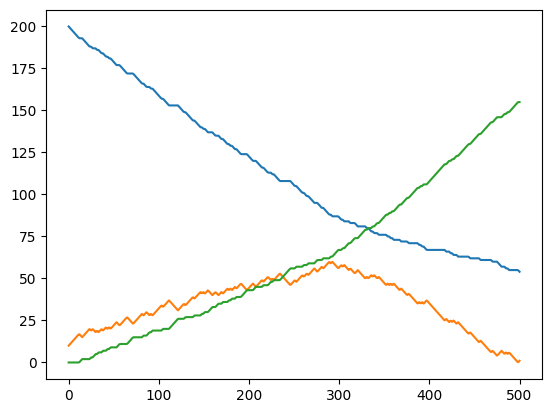

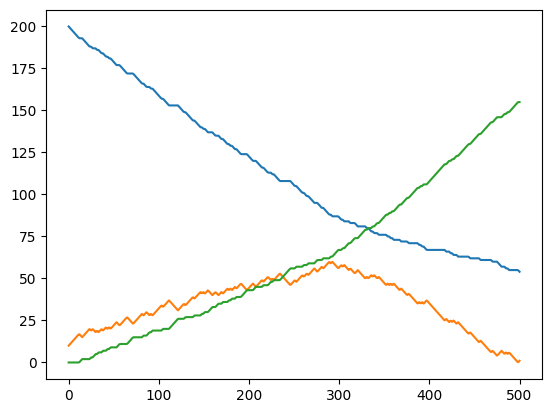

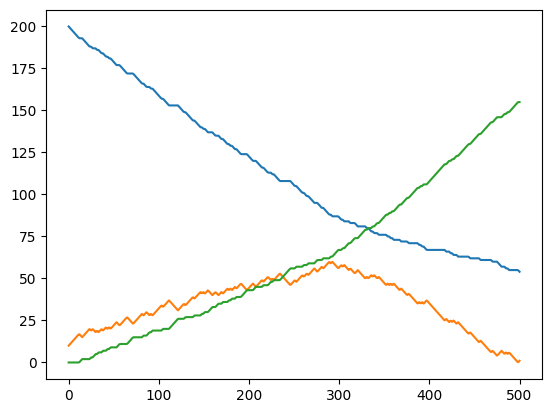

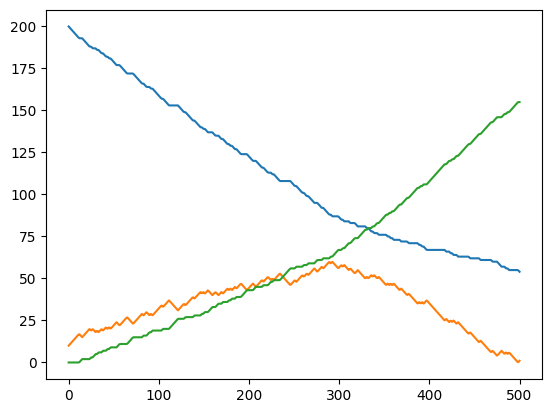

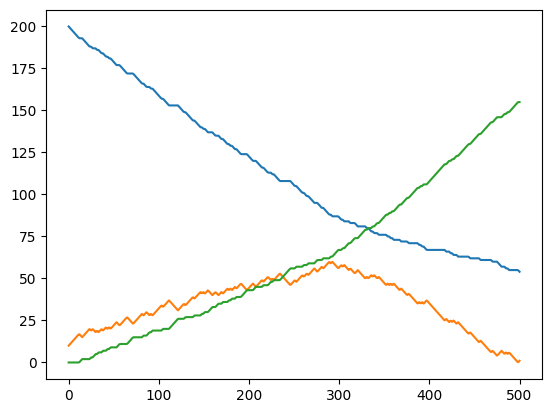

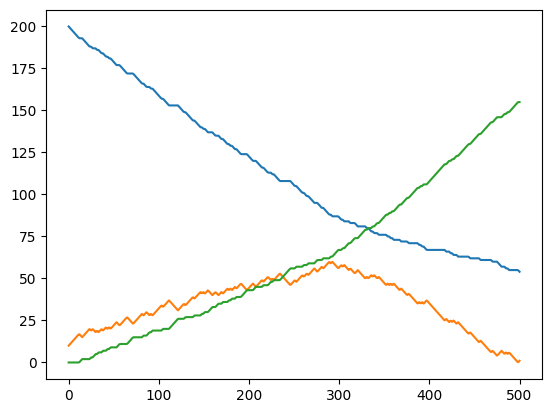

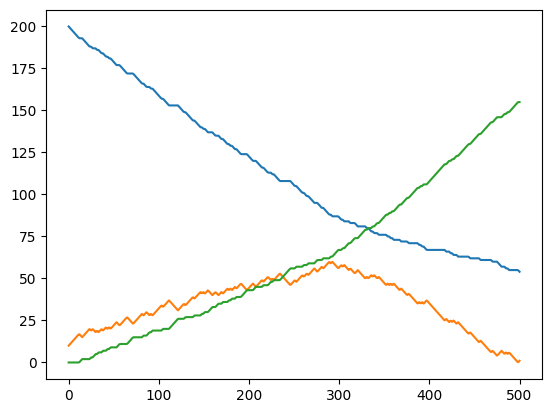

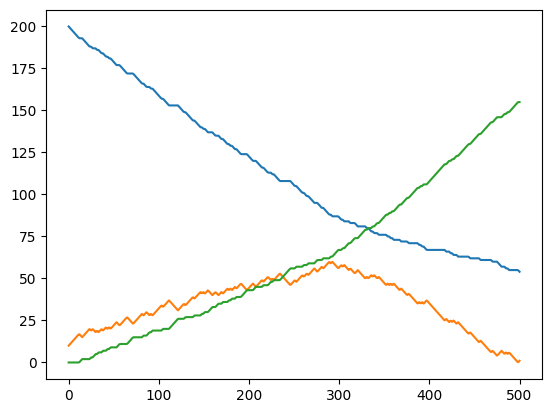

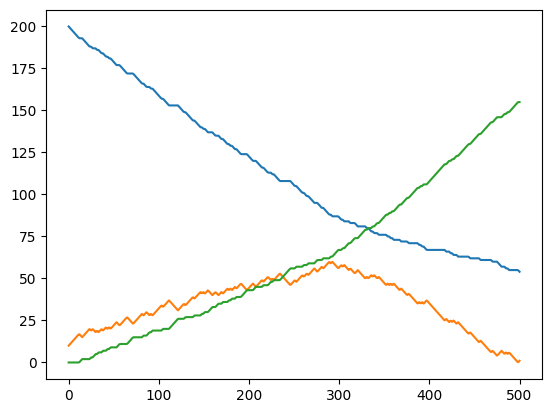

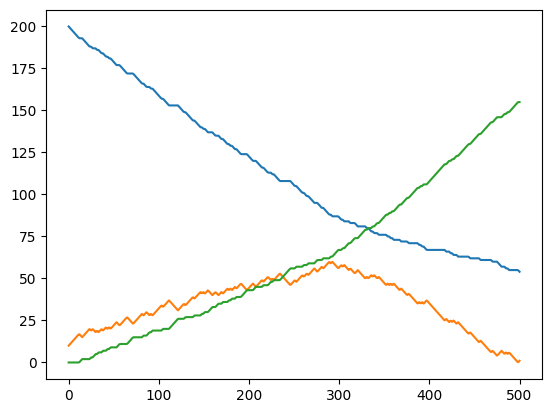

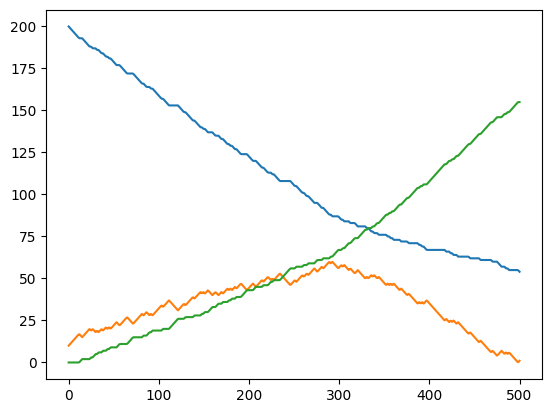

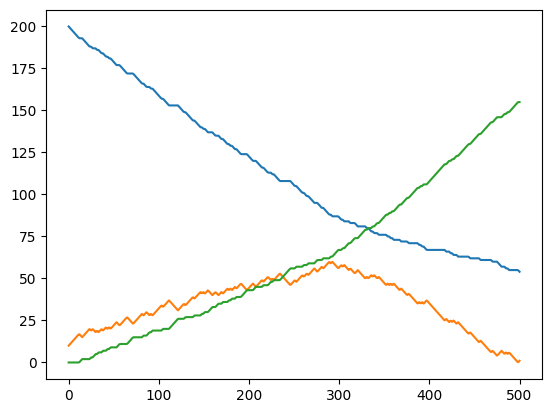

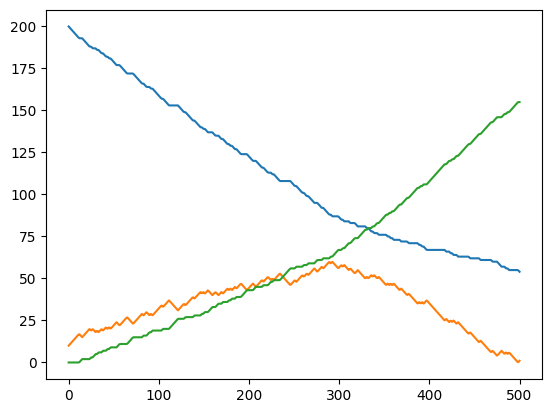

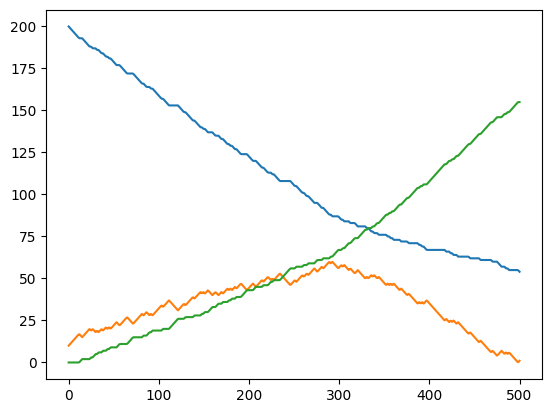

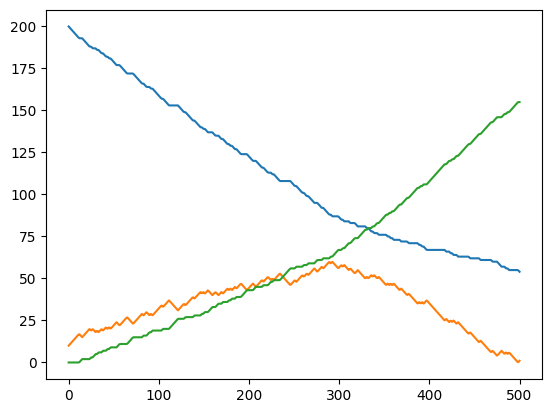

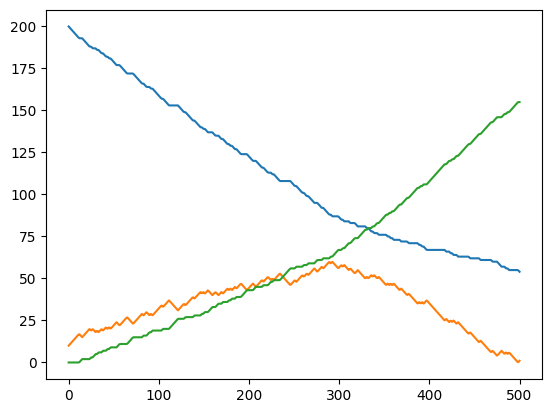

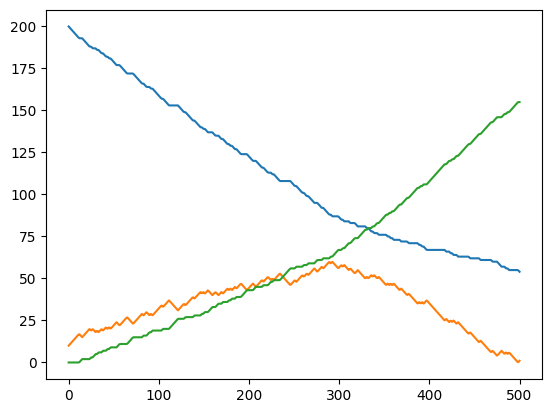

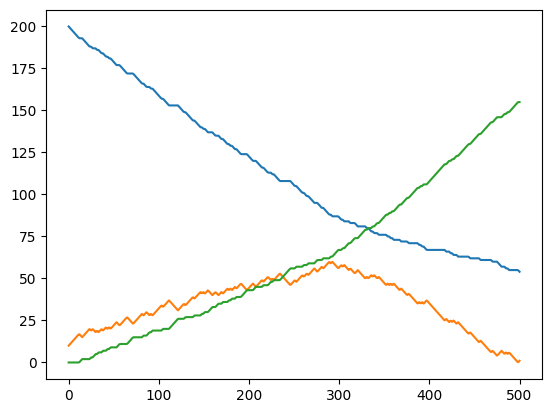

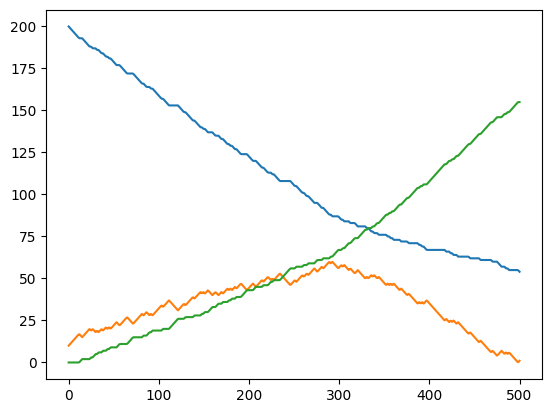

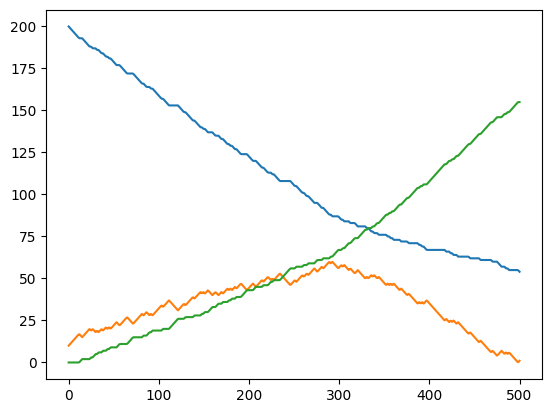

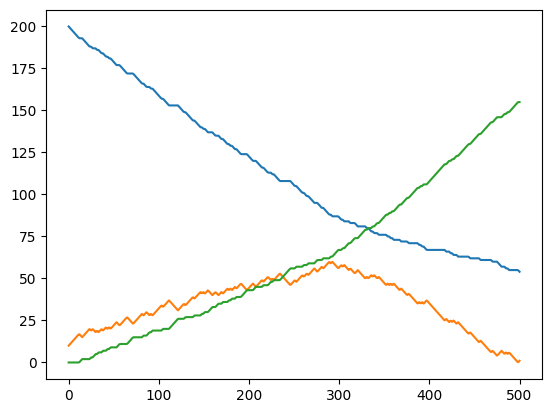

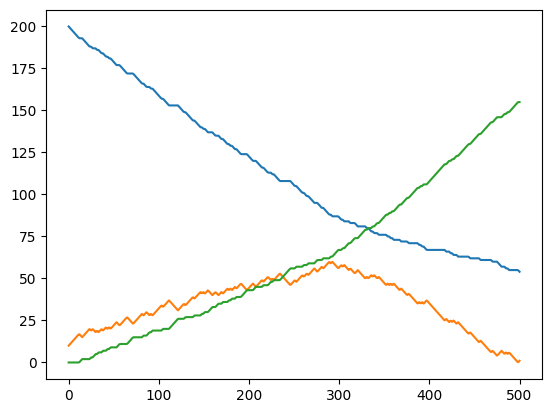

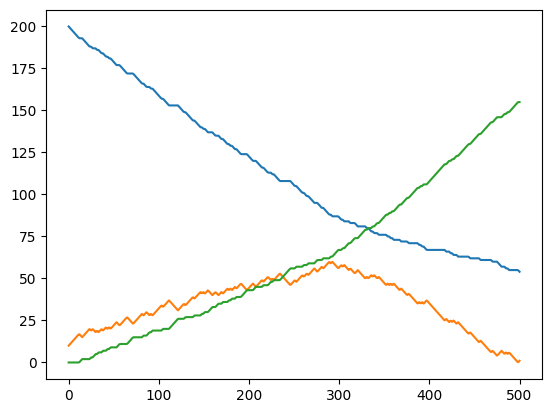

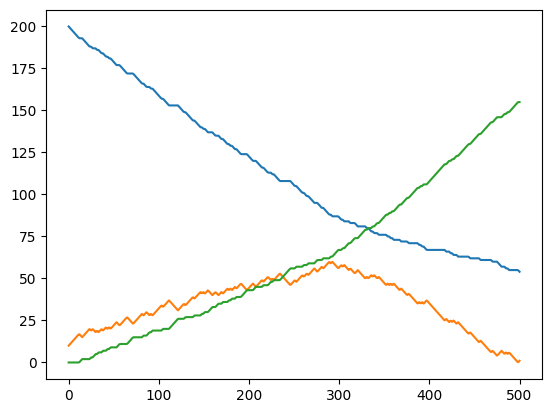

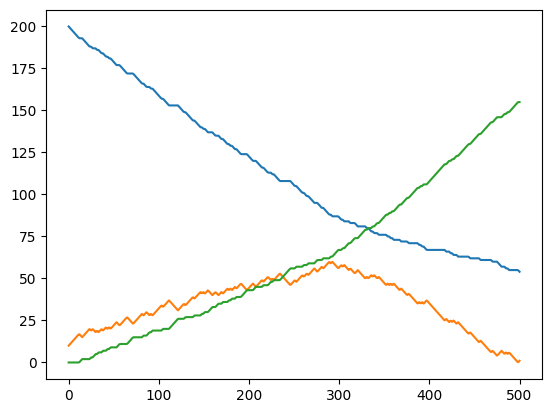

In [459]:
#non interpolation function
# common_t = np.linspace(0, tend, num=500)


common_t = np.linspace(0, tend, num=500)
results = []
for beta_gamma in combinations_beta_gamma:
    S_across_runs_interpolated = []
    I_across_runs_interpolated = []
    R_across_runs_interpolated = []
    for run in range(n_runs):
        S, I, R = Gillespies(S=S_init, I=I_init, R=R_init, t=t, tend=tend, beta = beta_gamma[0], gamma = beta_gamma[1])
        
        # interpolating values
        actual_t = np.linspace(0, tend, num=len(S))
        f_S = interp1d(actual_t, S, kind='linear', fill_value='extrapolate')
        f_I = interp1d(actual_t, I, kind='linear', fill_value='extrapolate')
        f_R = interp1d(actual_t, R, kind='linear', fill_value='extrapolate')
        # interpolating values
        S_across_runs_interpolated.append(f_S(common_t))
        I_across_runs_interpolated.append(f_I(common_t))
        R_across_runs_interpolated.append(f_R(common_t))
       
    
    

    S_mean = np.mean(S_across_runs_interpolated, axis = 0)
    I_mean = np.mean(I_across_runs_interpolated, axis = 0)
    R_mean = np.mean(R_across_runs_interpolated, axis = 0)
    S_var = np.var(S_across_runs_interpolated, axis = 0)
    I_var = np.var(I_across_runs_interpolated, axis = 0)
    R_var = np.var(R_across_runs_interpolated, axis = 0)

    plt.plot(common_t, S_mean, label='Mean S')
    plt.plot(common_t, I_mean, label='Mean I')
    plt.plot(common_t, R_mean, label='Mean R')
    plt.fill_between(common_t, S_mean - np.sqrt(S_var), S_mean + np.sqrt(S_var), alpha=0.2)
    plt.fill_between(common_t, I_mean - np.sqrt(I_var), I_mean + np.sqrt(I_var), alpha=0.2)
    plt.fill_between(common_t, R_mean - np.sqrt(R_var), R_mean + np.sqrt(R_var), alpha=0.2)
    plt.show()


    if np.sum(S_var) == 0:
        print("S_var is 0")
    if np.sum(I_var) == 0:
        print("I_var is 0")
    if np.sum(R_var) == 0:
        print("R_var is 0") 
    # covariance between S and I
    S_I_cov = np.cov(S_across_runs_interpolated, I_across_runs_interpolated)[0, 1]
    new_row = {
    'beta, gamma combination': beta_gamma,
    'S_mean': S_mean,
    'I_mean': I_mean,
    'R_mean': R_mean,
    'S_var': S_var,
    'I_var': I_var,
    'R_var': R_var,
    'cov(S,I)': S_I_cov
    }
    results.append(new_row)


In [460]:
df_q1 = pd.DataFrame(results)

In [461]:
df_q1

,"beta, gamma combination",S_mean,I_mean,R_mean,S_var,I_var,R_var,"cov(S,I)"
0,"(0.1, 1.0)","[200.0, 199.3967935871744, 198.7935871743487, ...","[10.0, 10.603206412825653, 11.2064128256513, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 8.077935669463161e-28, 0.0, 8.0779356694...","[0.0, 3.1554436208840472e-30, 3.15544362088404...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1920.081735
1,"(0.1, 0.775)","[200.0, 199.3967935871744, 198.7935871743487, ...","[10.0, 10.603206412825653, 11.2064128256513, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 8.077935669463161e-28, 0.0, 8.0779356694...","[0.0, 3.1554436208840472e-30, 3.15544362088404...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1920.081735
2,"(0.1, 0.55)","[200.0, 199.3967935871744, 198.7935871743487, ...","[10.0, 10.603206412825653, 11.2064128256513, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 8.077935669463161e-28, 0.0, 8.0779356694...","[0.0, 3.1554436208840472e-30, 3.15544362088404...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1920.081735
3,"(0.1, 0.325)","[200.0, 199.3967935871744, 198.7935871743487, ...","[10.0, 10.603206412825653, 11.2064128256513, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 8.077935669463161e-28, 0.0, 8.0779356694...","[0.0, 3.1554436208840472e-30, 3.15544362088404...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1920.081735
4,"(0.1, 0.1)","[200.0, 199.3967935871744, 198.7935871743487, ...","[10.0, 10.603206412825653, 11.2064128256513, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 8.077935669463161e-28, 0.0, 8.0779356694...","[0.0, 3.1554436208840472e-30, 3.15544362088404...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1920.081735
5,"(0.325, 1.0)","[200.0, 199.3967935871744, 198.7935871743487, ...","[10.0, 10.603206412825653, 11.2064128256513, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 8.077935669463161e-28, 0.0, 8.0779356694...","[0.0, 3.1554436208840472e-30, 3.15544362088404...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1920.081735
6,"(0.325, 0.775)","[200.0, 199.3967935871744, 198.7935871743487, ...","[10.0, 10.603206412825653, 11.2064128256513, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 8.077935669463161e-28, 0.0, 8.0779356694...","[0.0, 3.1554436208840472e-30, 3.15544362088404...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1920.081735
7,"(0.325, 0.55)","[200.0, 199.3967935871744, 198.7935871743487, ...","[10.0, 10.603206412825653, 11.2064128256513, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 8.077935669463161e-28, 0.0, 8.0779356694...","[0.0, 3.1554436208840472e-30, 3.15544362088404...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1920.081735
8,"(0.325, 0.325)","[200.0, 199.3967935871744, 198.7935871743487, ...","[10.0, 10.603206412825653, 11.2064128256513, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 8.077935669463161e-28, 0.0, 8.0779356694...","[0.0, 3.1554436208840472e-30, 3.15544362088404...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1920.081735
9,"(0.325, 0.1)","[200.0, 199.3967935871744, 198.7935871743487, ...","[10.0, 10.603206412825653, 11.2064128256513, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 8.077935669463161e-28, 0.0, 8.0779356694...","[0.0, 3.1554436208840472e-30, 3.15544362088404...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1920.081735


ValueError: x and y must have same first dimension, but have shapes (302,) and (500,)

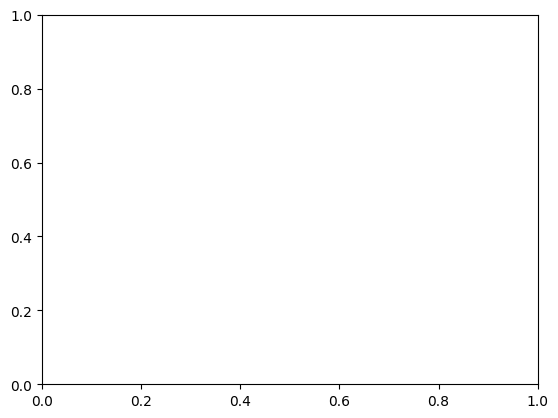

In [462]:
plt.plot(t, df_q1['S_mean'][0], label = "S")
plt.plot(t, df_q1['I_mean'][0], label = "I")
plt.plot(t, df_q1['R_mean'][0], label = "R")

In [463]:
pd.DataFrame([beta,gamma,mean_run,var_run, cov_S_I])

NameError: name 'mean_run' is not defined

ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count0
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count1
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count2
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count3
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words wh

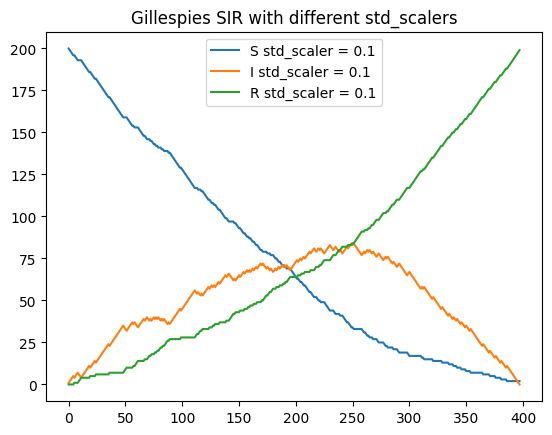

ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count0
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count1
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count2
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count3
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words wh

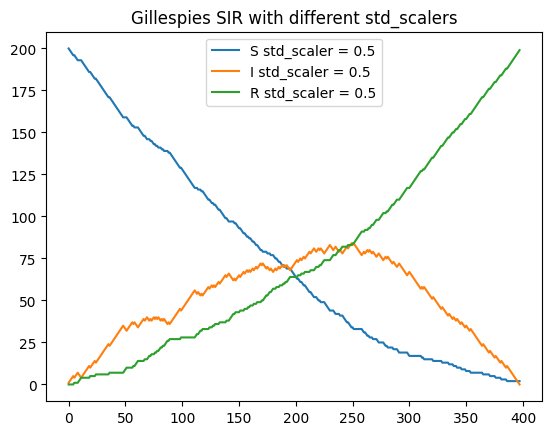

ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count0
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count1
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count2
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count3
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words wh

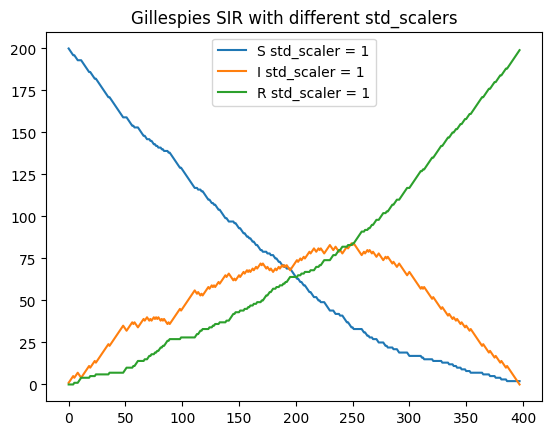

ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count0
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count1
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count2
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count3
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words wh

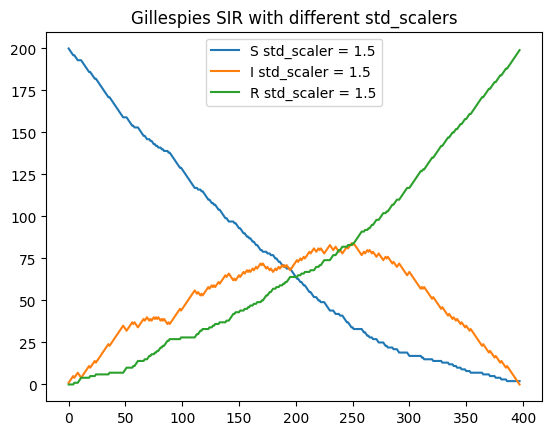

ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count0
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count1
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count2
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count3
ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words wh

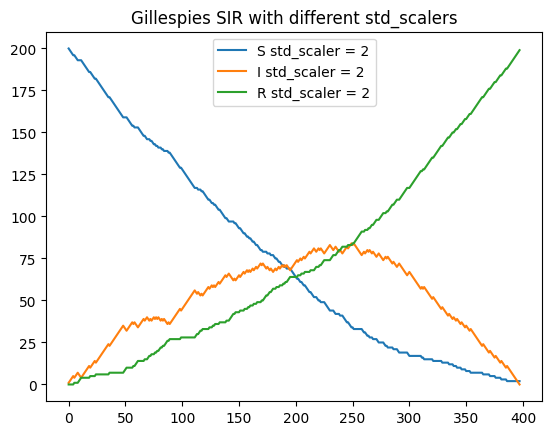

In [ ]:
# # simulating for multiple different params and plotting the results
# #skipping 0 as starting std_scaler because it leads to stochastic extinction every time
# std_scalers = [0.1, 0.5, 1, 1.5, 2]
# for std_scaler in std_scalers:
#     S, I, R = Gillespie(S_init, I_init, R_init, t, tend, beta, gamma, std_scaler)
#     plt.plot(S, label = f'S std_scaler = {std_scaler}')
#     plt.plot(I, label = f'I std_scaler = {std_scaler}')
#     plt.plot(R, label = f'R std_scaler = {std_scaler}')
#     plt.legend()
#     plt.title(f'Gillespies SIR with different std_scalers')
#     plt.show()
#     # save RMSE for each std_scaler
#     # S_ODE = y[:,0]
#     # I_ODE = y[:,1]

Investigate Simulation Variability and Negative Co-variance
In the first experiment you should investigate how varying the model parameters changes
the behaviour of the stochastic dynamics, in particular how they relate to variance between
runs and how they impact negative covariance between S and I. Compare the mean of
the stochastic simulations with the equivalent deterministic model output (do this for
multiple settings of the model parameters).

Stochastic Resonance and Increased Transients
Show how the stochastic model can induce stochastic resonance around the equilibrium
and how that resonance relates the model parameters (e.g., N, β), etc). Show some
examples of increased transients away from the deterministic equilibrium - can you show
which parameter values lead to the largest transients.

Extinction events and Critical Community Size
In the lectures we have discussed the possibility of extinction of the virus even when
R0 > 1 in closed populations. Design an experiment to show how varying R0 impacts
the extinction process. Keep in mind that in the closed system randomness will always
eventually lead to extinction. Now look at how the extinction events are impacted by
the population size. Find a way to show how the two parameters R0 and N interact to
impact the extinction process.

# Problem 2: Spatial Models - Networks

In this question you are asked to develop a set of experiments to design and evaluate
vaccination strategies using a network model. Using the package NDLib2 you should assess
the spread of a disease (SIR) across different types of model networks (Barabasi Albert,
Watts-Strogatz, Erdos-Reyni). Finally, you will run a simulated vaccination campaign
on a real contact network collected by sociopatterns (link). A modified version of this
dataset can be downloaded from Canvas, the network has been converted to a static
(non-temporal) form and some edges and nodes have been filtered out.

Implement SIR and Simulate
Implement SIR disease spread on the network. Think about your experimental design
and which parameters of the model you will want to vary. Design code that will allow
you run multiple simulations while varying the disease parameter.

Generate Networks of equivalent form
Using NetworkX generate multiple model networks with similar characteristics, again
think about the parameters associated with each network generator (e.g., Number of
nodes, connection probability,etc). Pick some network statistics (e.g., centrality measures,
degree distributions, etc.) that are interesting to measure in terms of spreading on the
network. You should generate multiple instances of each network type and then plot the
network statistics (you chose) and discuss how these statistic differ between network types
and for different parameter settings. You will use these generated networks in your SIR
experiments in the next part.

Simulate SIR spread on the network
Simulate epidemic spreading on the networks you generated in the previous section
(NOTE: the simulations will be stochastic so think about random seeds and repitions).
You can vary the fraction of initial infected, which nodes are initially infected and other
disease parameters. Compare and discuss how the disease spreads in the different networks
under different conditions.

Dynamic Vaccination Campaign
Finally, we will conduct vaccination experiments using the sociopatterns dataset, see
Figure 1. You should design some code to load in the sociopatterns dataset (this file on
canvas includes a simple edgelist and NDLib and NetworkX provide ways to import this)

Now consider a scenario in which a disease is spreading on this network. You should run
multiple experiments, but assume that the disease always starts with a random selection
of 5 nodes infected.

You are to design a dynamic vaccination strategy in which you have a testing budget and
a limited number of vaccinations available per iteration of the model. Assume that you
have 200 tests in total, you can use a maximum number of tests per iteration (this will
vary per experiment see below), you can of course use less. You can use the tests at any
point during the spread and you may repeat tests on a node as often as you like. You
can assume that you know the network structure, but you can only discover the disease
status of a node after a test. Vaccinations can only be applied to susceptible people and
that they immediately move people to the removed state. Finally, you might consider
situations where the tests are not always accurate, but instead have some probability
(which you can vary) of being accurate. You can also assume that people remain removed
until the end of the simulation (no waning immunity).
You should compare your strategy against a simple null strategy which randomly assigns
vaccinations, you should design a strategy that at least out performs the null strategy.
Compare the strategies with different vaccination budgets of [1, 3, 5 and 10] per timestep
and compare with different testing accuracy [0.5, 0.75, 1.0] . Finally, keep in mind that
the purpose of the assignment is not to design the best strategy, but to evaluate you
strategy in a systematic and scientific manner.